# Exploratory Data Analysis

In [9]:
import pandas as pd

input_data_path = '../input_data/'
features_df = pd.read_csv(f'{input_data_path}features.csv')
stores_df = pd.read_csv(f'{input_data_path}stores.csv')
weekly_sales_df = pd.read_csv(f'{input_data_path}weekly_sales.csv')

Primero limpiar data según requerimientos: **tiendas tipo B, con tamaño mayor a 100.000 y semanas con temperaturas mayores a 25°**

In [33]:
# Tipo B y tamaño mayor a 100k
valid_stores = stores_df.query("Type == 'B' and Size > 100000").Store.values

Rango de fechas y filtro de semanas por temperatura

In [43]:
print(pd.to_datetime(weekly_sales_df['Date']).max())
print(pd.to_datetime(weekly_sales_df['Date']).min())

2012-10-26 00:00:00
2010-02-05 00:00:00


In [46]:
print(pd.to_datetime(features_df['Date']).max())
print(pd.to_datetime(features_df['Date']).min())

2013-07-26 00:00:00
2010-02-05 00:00:00


Para el dataset de ventas, tenemos registros desde 2010-02-05 hasta 2012-10-26 (viernes).
En el dataset de Features, tenemos registros desde 2010-02-05 hasta 2013-07-26 (viernes).
Pero debemos pronosticar las siguientes 7 semanas, es decir, desde 2012-11-02 hasta el 2012-12-14 (viernes).
Entonces vamos a limitar nuestro dataset de features entre las fechas 2010-02-05 y 2012-12-14.
Además vamos a eliminar los registros en donde la temperatura sea igual o menor a 25

In [47]:
features_df.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [55]:
features_clean_df = features_df.query("Store in @valid_stores").copy(deep=True)
features_clean_df['Date'] = pd.to_datetime(features_clean_df['Date']) # Cast Date into datetime
features_clean_df = features_clean_df.query("'2010-02-05' <= Date <= '2012-12-14'") # Filtro de fechas
features_clean_df = features_clean_df.query("Temperature > 25")

In [67]:
survived = round(100 * (1 - (features_clean_df.shape[0] / features_df.shape[0])), 1)
print(f"El número de registros en el dataset de features disminuyó un {survived}% con los filtros aplicados")

El número de registros en el dataset de features disminuyó un 80.5% con los filtros aplicados


In [69]:
features_clean_df

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
1456,9,2010-02-05,38.01,2.572,NaN,NaN,NaN,NaN,NaN,214.655459,6.415,False
1457,9,2010-02-12,37.08,2.548,NaN,NaN,NaN,NaN,NaN,214.805653,6.415,True
1458,9,2010-02-19,43.06,2.514,NaN,NaN,NaN,NaN,NaN,214.850618,6.415,False
1459,9,2010-02-26,43.83,2.561,NaN,NaN,NaN,NaN,NaN,214.878045,6.415,False
1460,9,2010-03-05,48.43,2.625,NaN,NaN,NaN,NaN,NaN,214.905472,6.415,False
...,...,...,...,...,...,...,...,...,...,...,...,...
8153,45,2012-11-16,45.61,3.750,18700.38,499.75,28.20,1800.78,10303.93,192.261619,8.667,False
8154,45,2012-11-23,43.08,3.748,1005.79,NaN,72542.01,484.70,620.12,192.283032,8.667,True
8155,45,2012-11-30,37.43,3.729,2298.55,NaN,2908.54,100.86,1344.84,192.304445,8.667,False
8156,45,2012-12-07,45.53,3.688,9273.32,NaN,263.41,1979.78,11324.83,192.325858,8.667,False


Se observa que existen muchos valores NaN en las columnas MarkDown, cuantos NaN existen por columna?

In [70]:
features_clean_df.isna().sum()

Store              0
Date               0
Temperature        0
Fuel_Price         0
MarkDown1        967
MarkDown2       1136
MarkDown3       1011
MarkDown4        969
MarkDown5        967
CPI                0
Unemployment       0
IsHoliday          0
dtype: int64

Existe un alto número de valores nulos en MarkDown1-5, es posible que en esas semanas no existieran promociones y descuentos, podriamos reemplazar esos valores por 0. Utilizaremos este supuesto más adelante

## Limpieza de Ventas Semanales (tiendas y semanas)

In [79]:
clean_weekly_sales = weekly_sales_df.query("Store in @valid_stores").copy(deep=True)
clean_weekly_sales['Date'] = pd.to_datetime(clean_weekly_sales['Date']) # Cast Date into datetime

In [91]:
clean_weekly_sales

,Store,Dept,Date,Weekly_Sales,IsHoliday
78657,9,1,2010-02-05,12861.40,False
78658,9,1,2010-02-12,20273.94,True
78659,9,1,2010-02-19,14819.97,False
78660,9,1,2010-02-26,10530.98,False
78661,9,1,2010-03-05,10438.47,False
...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,False
421566,45,98,2012-10-05,628.10,False
421567,45,98,2012-10-12,1061.02,False
421568,45,98,2012-10-19,760.01,False


No tenemos features específicas para Dept (departamentos), es posible que sea mejor realizar la predicciónes por las tiendas completas, y no una para cada departamento.

In [97]:
store_weekly_sales = clean_weekly_sales.groupby(['Store', 'Date', 'IsHoliday']).sum().reset_index().drop(columns=['Dept'])

In [102]:
# Revisar si existen pares duplicados [Store, Date] (por algún error en la columna IsHoliday)
store_weekly_sales[store_weekly_sales.duplicated(subset=['Store','Date'], keep=False)]

,Store,Date,IsHoliday,Weekly_Sales


In [104]:
total_weekly_sales = clean_weekly_sales.groupby(['Date', 'IsHoliday']).sum().reset_index().drop(columns=['Store', 'Dept'])

In [107]:
# Revisar si existen pares duplicados [Date, IsHoliday] (por algún error en la columna IsHoliday)
total_weekly_sales[total_weekly_sales.duplicated(subset=['IsHoliday','Date'], keep=False)]

,Date,IsHoliday,Weekly_Sales


In [108]:
total_weekly_sales

,Date,IsHoliday,Weekly_Sales
0,2010-02-05,False,11694898.08
1,2010-02-12,True,11338849.87
2,2010-02-19,False,11495206.55
3,2010-02-26,False,10401334.38
4,2010-03-05,False,11030603.21
...,...,...,...
138,2012-09-28,False,9801584.18
139,2012-10-05,False,10436585.09
140,2012-10-12,False,10208583.45
141,2012-10-19,False,10057643.14


Tenemos registros para 143 semanas, y necesitamos predecir las siguientes 7 semanas

## Algunos gráficos sobre ventas por departamento y tienda

In [113]:
clean_weekly_sales_plt = clean_weekly_sales.set_index('Date')
store_weekly_sales_plt = store_weekly_sales.set_index('Date')
total_weekly_sales_plt = total_weekly_sales.set_index('Date')


<AxesSubplot: xlabel='Date'>

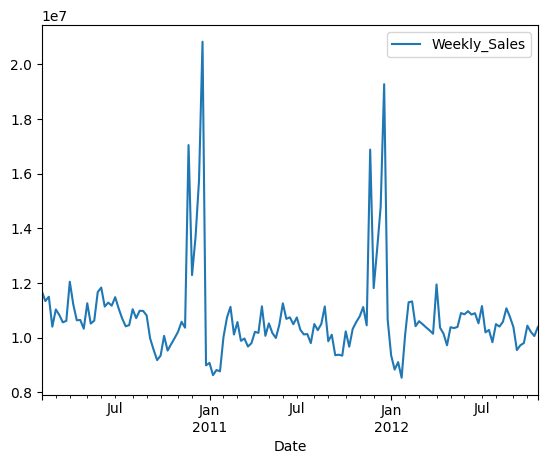

In [116]:
total_weekly_sales_plt.loc[:,['Weekly_Sales']].plot.line()

En el gráfico de ventas totales se muestra un fuerte peak de ventas entre el periodo Noviembre - Diciembre (El mismo periodo que se pide pronosticar)

In [117]:
store_weekly_sales_plt.head(2)

,Store,IsHoliday,Weekly_Sales
Date,,,
2010-02-05,9,False,549505.55
2010-02-12,9,True,552677.48


<AxesSubplot: xlabel='Date'>

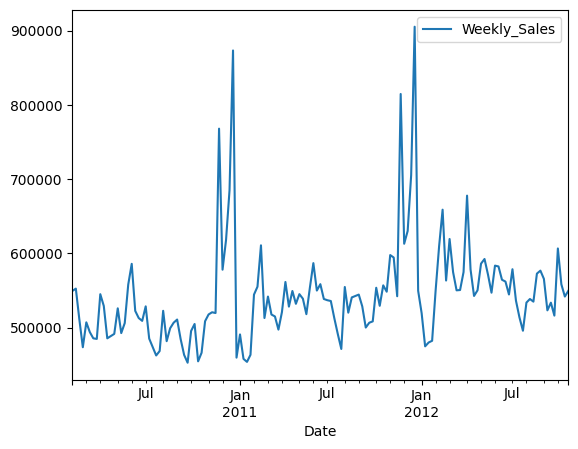

In [118]:
store_weekly_sales_plt.query("Store == 9").loc[:,['Weekly_Sales']].plot.line()

<AxesSubplot: xlabel='Date'>

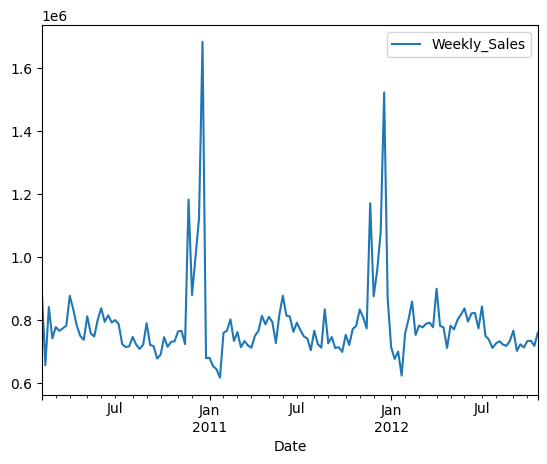

In [129]:
store_weekly_sales_plt.query("Store == 45").loc[:,['Weekly_Sales']].plot.line()

En estas dos tiendas se mantienen patrones similares a los observados en la serie de tiempo total

In [119]:
clean_weekly_sales_plt.head(2)

,Store,Dept,Weekly_Sales,IsHoliday
Date,,,,
2010-02-05,9,1,12861.40,False
2010-02-12,9,1,20273.94,True


<AxesSubplot: xlabel='Date'>

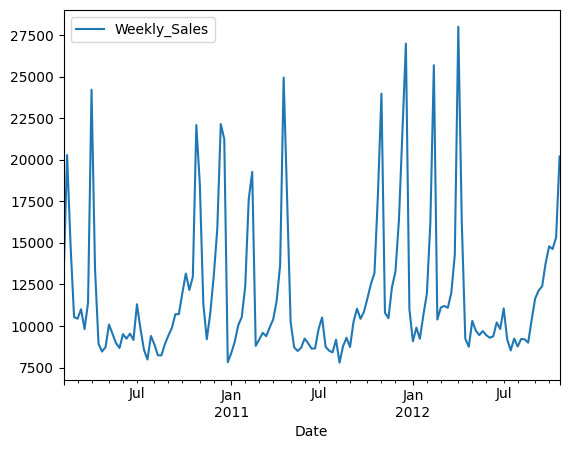

In [122]:
clean_weekly_sales_plt.query("Store == 9 and Dept == 1").loc[:,['Weekly_Sales']].plot.line()

<AxesSubplot: xlabel='Date'>

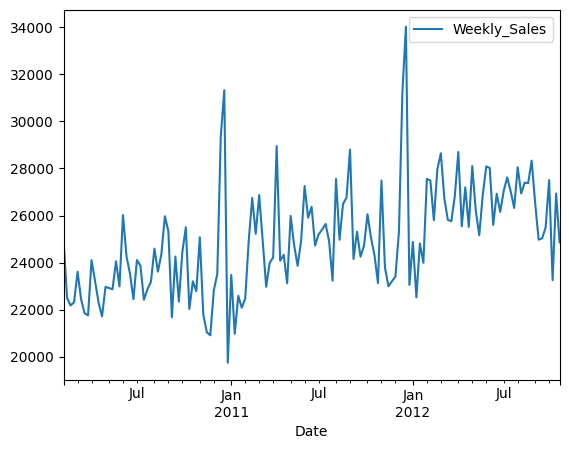

In [127]:
clean_weekly_sales_plt.query("Store == 9 and Dept == 2").loc[:,['Weekly_Sales']].plot.line()

Cuando observamos estos departamentos, se pierde el patrón de ventas de la serie total y de tienda. Añadir la separación de departamentos puede añadir mucho ruido a la series de tiempo.

### Efecto Holidays en Ventas

<AxesSubplot: xlabel='Date'>

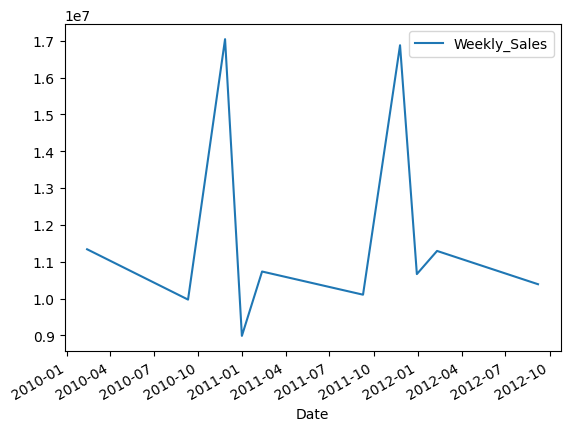

In [132]:
total_weekly_sales_plt.query("IsHoliday == True").loc[:,['Weekly_Sales']].plot.line()

<AxesSubplot: xlabel='Date'>

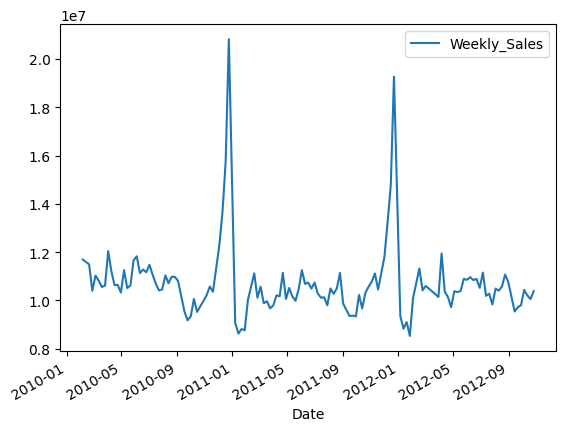

In [133]:
total_weekly_sales_plt.query("IsHoliday == False").loc[:,['Weekly_Sales']].plot.line()

El tag IsHoliday no captura correctamente el efecto del peak de ventas, parece tener más relación con el número de la semana 

## Semanas a predecir vs mismas semanas 2011 y 2010
Es posible que la magnitud de las ventas entre estas semanas sea tan alto, que el resto de las semanas del año no sean tan útiles para predecir.

In [152]:
dates = {'Date': [
    '2012-11-02',
    '2012-11-09',
    '2012-11-16',
    '2012-11-23',
    '2012-11-30',
    '2012-12-07',
    '2012-12-14']}
forecast_dates = pd.DataFrame(data=dates)
forecast_dates['Date'] = pd.to_datetime(forecast_dates['Date'])
forecast_dates['Week'] = forecast_dates['Date'].dt.isocalendar().week

In [153]:
forecast_dates

,Date,Week
0,2012-11-02,44
1,2012-11-09,45
2,2012-11-16,46
3,2012-11-23,47
4,2012-11-30,48
5,2012-12-07,49
6,2012-12-14,50


In [160]:
week_comparison_total = total_weekly_sales_plt.reset_index()
week_comparison_total['Week'] = week_comparison_total['Date'].dt.isocalendar().week
week_comparison_total

,Date,IsHoliday,Weekly_Sales,Week
0,2010-02-05,False,11694898.08,5
1,2010-02-12,True,11338849.87,6
2,2010-02-19,False,11495206.55,7
3,2010-02-26,False,10401334.38,8
4,2010-03-05,False,11030603.21,9
...,...,...,...,...
138,2012-09-28,False,9801584.18,39
139,2012-10-05,False,10436585.09,40
140,2012-10-12,False,10208583.45,41
141,2012-10-19,False,10057643.14,42


In [163]:
week_comparison_total.query("40 <= Week <= 52")

,Date,IsHoliday,Weekly_Sales,Week
35,2010-10-08,False,10064797.88,40
36,2010-10-15,False,9525027.36,41
37,2010-10-22,False,9756376.71,42
38,2010-10-29,False,9977792.18,43
39,2010-11-05,False,10216271.81,44
40,2010-11-12,False,10577447.84,45
41,2010-11-19,False,10363491.89,46
42,2010-11-26,True,17045596.27,47
43,2010-12-03,False,12288233.17,48
44,2010-12-10,False,13674443.38,49


In [164]:
week_comparison_total.query("36 <= Week <= 43")

,Date,IsHoliday,Weekly_Sales,Week
31,2010-09-10,True,9971681.99,36
32,2010-09-17,False,9553476.54,37
33,2010-09-24,False,9176907.35,38
34,2010-10-01,False,9341212.98,39
35,2010-10-08,False,10064797.88,40
36,2010-10-15,False,9525027.36,41
37,2010-10-22,False,9756376.71,42
38,2010-10-29,False,9977792.18,43
83,2011-09-09,True,10104891.14,36
84,2011-09-16,False,9354382.06,37


# Conclusiones

No existe un patrón claro entre la features IsHoliday, Markdown, Temperature, Fuel, CPI y Unenmployment y las ventas de las semanas 44-50.

Entre la semana 47 y 51 de los años 2010 y 2011 existe un notorio peak de demanda. Lo que se puede explicar por las compras previas a la navidad, y día de thanksgiving en USA. Es esperable un peak similar para el año 2012 y los siguientes.

La magnitud de ventas es similar en las últimas 7 semanas (36-43) entre los años 2010, 2011 y 2012

El gran problema que veo en este momento, es que tenemos muy registros para el caso de alta demanda entre la semana 47 y 51. Es probable que un modelo de machine learning complejo no pueda encontrar patrones correctos con tan poca cantidad de registros.

Es probable que un sistema mucho más simple como una regresión lineal entregue mejores resultados. Dado que los patrones de venta son muy similares entre un año y otro, comparando el mismo número de semanas.

Voy a experimentar con algoritmos de regresión lineal (o más simples aún) para pronosticar las semanas 36-43 y luego medir su precisión.

In [168]:
week_comparison_total.drop(columns=['IsHoliday']).to_csv("../clean_data/weekly_sales_total.csv", index=False)